This notebook is a simple walkthrough of what's possible with XArray for resonant scattering, and a demonstration of the library I've been developing.

The library has a few discrete modules:

1) File loaders.  These abstract away the details of getting raw data into a raw xarray and correcting the intensity (which lives here because it tends ot be metadata-intensive).  To add support for a new beamline you simply write a class that inherits from FileLoader with one method that opens the file, formats it into an xarray, and cleans up the metadata to include standard terms like exposure, energy, pos_x, pos_th, etc.

(optionally, data preprocessors like HDRSoXS exposure stitching can live between these two steps.)

2) Integrators.  These abstract away the details of conversion from a raw xarray to a chi,q xarray.  I provide a pyFAI based general purpose integrator (no parameters change within an array) and an energy series integrator (energy changes in an array and is handled efficiently).  Implementing other geometries (e.g. a detector moving) would be handled by subclassing the general integrator.  Implementing other backends (for example, pyGix) is also easy by just supporting the same integrateSingleImage(img) and integrateImageStack(img_stack) methods.

(you can slice the data here easily with standard xarray selector methods - as demonstrated below - or process it)

3) Fitting.  The fits are very simple to write, I provide a few demos here for lorentz and gauss peaks.  I think there are better curve fitting backends than scipy.optimize.curve_fit (lm_fit?) but that's what I used.


First, we import the modules we're going to use: (note the hack to put the library directory on the path)

In [1]:
import sys
sys.path.append("../PyHyperScattering/")

from ALS11012RSoXSLoader import ALS11012RSoXSLoader

from PFEnergySeriesIntegrator import PFEnergySeriesIntegrator

import HDR

In [2]:
%load_ext autoreload
%autoreload 2

Next, we configure the loader with dark images and correction details.

In [3]:
loader = ALS11012RSoXSLoader(corr_mode='expt',dark_pedestal=200)
loader.loadSampleSpecificDarks("../example_data/CCD/PSg/",md_filter={'sampleid':11})

Loading dark for 0.001 from L2_PSg_B_PZS_62757-00002.fits
Loading dark for 0.1 from L2_PSg_B_PZS_62757-00003.fits
Loading dark for 1.0 from L2_PSg_B_PZS_62757-00004.fits


Let's load an image stack:

In [4]:
import os 
files = os.listdir('../example_data/CCD/PSg')

filenumber_coord = {}
for file in files:
    if '.fits' in file:
        filenumber_coord.update({file:int(file[-10:-5])})

What we just made is a dictionary of filename:number pairs - a coordinate!  You could use the filename to get other data, e.g. temperature, from an outside source.

To use this coordinate, you do two things. 

(1) Pass the {filename:value,filename:value} dict you created in coords, as an entry of another dict where the key is the name of the parameter, e.g.
'filenumber':filenumber coord.

(2) Tell the loader you want your new attribute to be used as a dimension of the resulting dataset by adding the name to dims.

So, next we're going to load a series.  The arguments here are path, dimensions (what axes we want the resulting xarray to have), coordinates (extra axes we generated, as above), and finally a metadata filter to suppress certain files.  In this case we only want a single sample number so we say to ignore files where sampleid is not 11.

In [5]:
raw_xr = loader.loadFileSeries(
                                '../example_data/CCD/PSg/',
                               ['energy','polarization','exposure','filenumber'],
                               coords = {'filenumber':filenumber_coord},
                               md_filter={'sampleid':11,'CCD Shutter Inhibit':0}
                              )

Found 461 files.
Not loading L2_PSg_B_PZS_62758-00145.fits, expected sampleid to be 11 but it was 12.0
Not loading L2_PSg_B_PZS_62758-00112.fits, expected sampleid to be 11 but it was 12.0
Not loading L2_PSg_B_PZS_62758-00057.fits, expected sampleid to be 11 but it was 12.0
Not loading L2_PSg_B_PZS_62758-00104.fits, expected sampleid to be 11 but it was 12.0
Not loading L2_PSg_B_PZS_62758-00041.fits, expected sampleid to be 11 but it was 12.0
Not loading L2_PSg_B_PZS_62758-00153.fits, expected sampleid to be 11 but it was 12.0
Not loading L2_PSg_B_PZS_62758-00016.fits, expected sampleid to be 11 but it was 12.0
Not loading L2_PSg_B_PZS_62758-00082.fits, expected sampleid to be 11 but it was 12.0
Not loading L2_PSg_B_PZS_62758-00128.fits, expected sampleid to be 11 but it was 12.0
Not loading L2_PSg_B_PZS_62758-00201.fits, expected sampleid to be 11 but it was 12.0
Not loading L2_PSg_B_PZS_62758-00190.fits, expected sampleid to be 11 but it was 12.0
Not loading L2_PSg_B_PZS_62758-00256.

Let's look at this xarray:

In [6]:
raw_xr


<xarray.DataArray (system: 184, pix_x: 1024, pix_y: 1024)>
array([[[  207.58483034,   182.63473054,   200.5988024 , ...,
           212.5748503 ,   156.68662675,   201.59680639],
        [  184.63073852,   196.60678643,   197.60479042, ...,
           210.57884232,   194.61077844,   201.59680639],
        [  198.60279441,   210.57884232,   203.59281437, ...,
           188.62275449,   187.6247505 ,   194.61077844],
        ...,
        [  221.55688623,   249.500998  ,   228.54291417, ...,
           189.62075848,   233.53293413,   212.5748503 ],
        [  233.53293413,   264.47105788,   236.52694611, ...,
           202.59481038,   176.64670659,   200.5988024 ],
        [  228.54291417,   263.47305389,   224.5508982 , ...,
           183.63273453,   188.62275449,   210.57884232]],

       [[ 2058.82352941,  2009.80392157,  1754.90196078, ...,
          2009.80392157,  1941.17647059,  1921.56862745],
        [ 2039.21568627,  1862.74509804,  1892.15686275, ...,
          2117.64705882,  1960.78431373,  1843.1372549 ],
        [ 1931.37254902,  1950.98039216,  2117.64705882, ...,
          1911.76470588,  1960.78431373,  2029.41176471],
        ...,
        [ 1892.15686275,  2019.60784314,  1960.78431373, ...,
          2000.        ,  2029.41176471,  1862.74509804],
        [ 1990.19607843,  2088.23529412,  2009.80392157, ...,
          1950.98039216,  1960.78431373,  2039.21568627],
        [ 2078.43137255,  1990.19607843,  2107.84313725, ...,
          1980.39215686,  1823.52941176,  1892.15686275]],

       [[  208.58283433,   192.61477046,   206.58682635, ...,
           196.60678643,   144.71057884,   190.61876248],
        [  183.63273453,   188.62275449,   206.58682635, ...,
           193.61277445,   194.61077844,   186.62674651],
        [  185.62874251,   209.58083832,   184.63073852, ...,
           197.60479042,   187.6247505 ,   198.60279441],
        ...,
        [  216.56686627,   199.6007984 ,   201.59680639, ...,
           191.61676647,   228.54291417,   216.56686627],
        [  190.61876248,   196.60678643,   215.56886228, ...,
           218.56287425,   182.63473054,   196.60678643],
        [  221.55688623,   197.60479042,   200.5988024 , ...,
           191.61676647,   189.62075848,   213.57285429]],

       ...,

       [[ 2058.82352941,  1970.58823529,  1794.11764706, ...,
          1990.19607843,  2088.23529412,  1941.17647059],
        [ 2098.03921569,  1872.54901961,  2088.23529412, ...,
          2049.01960784,  1941.17647059,  1882.35294118],
        [ 1970.58823529,  1813.7254902 ,  1784.31372549, ...,
          1872.54901961,  1882.35294118,  2068.62745098],
        ...,
        [ 1813.7254902 ,  1872.54901961,  2127.45098039, ...,
          1882.35294118,  2117.64705882,  1794.11764706],
        [ 2000.        ,  1970.58823529,  1941.17647059, ...,
          1911.76470588,  1980.39215686,  1960.78431373],
        [ 2147.05882353,  1980.39215686,  2019.60784314, ...,
          1950.98039216,  1941.17647059,  1931.37254902]],

       [[ 2029.41176471,  1882.35294118,  1696.07843137, ...,
          1823.52941176,  1931.37254902,  1931.37254902],
        [ 1980.39215686,  1852.94117647,  2039.21568627, ...,
          2186.2745098 ,  1970.58823529,  2009.80392157],
        [ 1950.98039216,  1960.78431373,  1921.56862745, ...,
          1852.94117647,  1911.76470588,  2049.01960784],
        ...,
        [ 2058.82352941,  1911.76470588,  2088.23529412, ...,
          2019.60784314,  2127.45098039,  1754.90196078],
        [ 1911.76470588,  1862.74509804,  2098.03921569, ...,
          1990.19607843,  2009.80392157,  1970.58823529],
        [ 2176.47058824,  2049.01960784,  2019.60784314, ...,
          1911.76470588,  1852.94117647,  1745.09803922]],

       [[68000.        , 67666.66666667, 73333.33333333, ...,
         63000.        , 69333.33333333, 66000.        ],
        [67333.33333333, 68666.66666667, 67333.33333333, ...,
         73333.33333333, 70666.66666667, 69666.66666667],
        [6433

In [7]:
raw_hdr = HDR.scaleAndMask(raw_xr)

Grouping by: ['energy', 'polarization']
Grouping on polarization
  number of groups 2
    Launching workOrRecurse with xr, groupby ['energy'], coords {'polarization': 100.0}
Grouping on energy
  number of groups 55
    Launching workOrRecurse with xr, groupby [], coords {'polarization': 100.0, 'energy': 270.0}
        Processing exposure 0.003
                Masking hi: pixels >= 45000 cts or 15000000.0 cps resulted in 2 pixels masked
                Masking lo: pixels <= 20 cts or 6666.666666666667 cps resulted in 0 pixels masked
            masking resulted in 2 masked pixels
            binary closing completed, masked pixels 2 --> 2
        Processing exposure 0.10200000000000001
                Masking hi: pixels >= 45000 cts or 441176.47058823524 cps resulted in 157 pixels masked
                Masking lo: pixels <= 20 cts or 196.078431372549 cps resulted in 0 pixels masked
            masking resulted in 157 masked pixels
            binary closing completed, masked pixels 157

In [8]:
raw_hdr

<xarray.DataArray (system: 112, pix_x: 1024, pix_y: 1024)>
array([[[  578.59078591,   569.55736224,   557.81391147, ...,
           529.35862692,   511.74345077,   539.29539295],
        [  535.68202349,   497.74164408,   550.13550136, ...,
           562.33062331,   537.48870822,   566.84733514],
        [  556.91056911,   546.52213189,   558.26558266, ...,
           523.48690154,   530.26196929,   568.20234869],
        ...,
        [  542.90876242,   588.97922313,   575.42908762, ...,
           546.0704607 ,   574.07407407,   534.77868112],
        [  569.10569106,   542.90876242,   600.72267389, ...,
           551.03884372,   550.13550136,   558.71725384],
        [  579.94579946,   560.52393857,   557.81391147, ...,
           527.55194219,   552.84552846,   568.65401987]],

       [[ 3980.95238095,  3828.57142857,  3752.38095238, ...,
          3571.42857143,  3876.19047619,  3819.04761905],
        [ 3942.85714286,  3704.76190476,  3952.38095238, ...,
          4104.76190476,  4009.52380952,  3923.80952381],
        [ 3742.85714286,  3819.04761905,  4095.23809524, ...,
          3790.47619048,  3847.61904762,  4190.47619048],
        ...,
        [ 3609.52380952,  3857.14285714,  3885.71428571, ...,
          3800.        ,  3895.23809524,  3704.76190476],
        [ 3790.47619048,  3657.14285714,  3638.0952381 , ...,
          3685.71428571,  3914.28571429,  3990.47619048],
        [ 3990.47619048,  3666.66666667,  3866.66666667, ...,
          3580.95238095,  3600.        ,  3847.61904762]],

       [[ 3990.47619048,  3961.9047619 ,  3914.28571429, ...,
          3561.9047619 ,  3838.0952381 ,  4000.        ],
        [ 3761.9047619 ,  3752.38095238,  3857.14285714, ...,
          4114.28571429,  3904.76190476,  3780.95238095],
        [ 3980.95238095,  3914.28571429,  4019.04761905, ...,
          3780.95238095,  3933.33333333,  4019.04761905],
        ...,
        [ 3600.        ,  3742.85714286,  3866.66666667, ...,
          3828.57142857,  4114.28571429,  3504.76190476],
        [ 3838.0952381 ,  3885.71428571,  3685.71428571, ...,
          3695.23809524,  3923.80952381,  3904.76190476],
        [ 3961.9047619 ,  3885.71428571,  3733.33333333, ...,
          3914.28571429,  3857.14285714,  3942.85714286]],

       ...,

       [[69000.        , 69000.        , 74000.        , ...,
         60333.33333333, 67333.33333333, 66333.33333333],
        [67333.33333333, 69333.33333333, 68333.33333333, ...,
         70333.33333333, 67333.33333333, 70000.        ],
        [69666.66666667, 64333.33333333, 74666.66666667, ...,
         67666.66666667, 65666.66666667, 62333.33333333],
        ...,
        [64666.66666667, 67666.66666667, 67333.33333333, ...,
         62333.33333333, 72333.33333333, 64666.66666667],
        [64000.        , 62000.        , 67333.33333333, ...,
         65666.66666667, 73666.66666667, 70000.        ],
        [72333.33333333, 64333.33333333, 68333.33333333, ...,
         64666.66666667, 69333.33333333, 69666.66666667]],

       [[  392.039801  ,   389.05472637,   412.93532338, ...,
           404.97512438,   363.1840796 ,   413.93034826],
        [  410.94527363,   402.98507463,   372.13930348, ...,
           403.9800995 ,   399.00497512,   410.94527363],
        [  408.95522388,   407.960199  ,   417.91044776, ...,
           404.97512438,   378.10945274,   397.01492537],
        ...,
        [  398.00995025,   456.71641791,   431.84079602, ...,
           373.13432836,   419.90049751,   395.02487562],
        [  428.85572139,   424.87562189,   402.98507463, ...,
           410.94527363,   383.08457711,   403.9800995 ],
        [  428.85572139,   418.90547264,   427.86069652, ...,
           381.09452736,   385.07462687,   421.89054726]],

       [[ 1911.76470588,  2215.68627451,  1872.54901961, ...,
          1843.1372549 ,  2078.43137255,  1970.58823529],
        [ 1990.19607843,  1862.74509804,  2107.84313725, ...,
          2107.84313725,  1990.19607843,  1980.39215686],
        [ 183

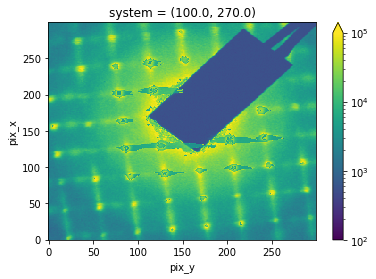

In [12]:
from matplotlib.colors import LogNorm
raw_hdr.sel(energy=270,polarization=100,method='nearest').sel(pix_x=slice(400,700),pix_y=slice(400,700)).plot(norm=LogNorm(1e2,1e5))

In [12]:
raw_xr.sel(energy=270,polarization=100,method='nearest').sel(exposure=slice(0.9,1.1)).plot(norm=LogNorm(1e0,1e5))


OK, let's try integrating this to get something useful!

We set up an integrator - the integrator supports calibrations from Nika and masks from Nika to make life easier.

In [14]:
integrator = PFEnergySeriesIntegrator(maskmethod = "nika",maskpath = "../example_data/LowQ_mask.hdf",
                                 geomethod="nika",NIdistance=131.06, NIbcx=(561.76), NIbcy=(1024-452.33),
                                 
                                 integration_method='csr_ocl')


Imported Nika mask, dimensions (1024, 1024)


Let's take our test image from before and integrate it:

We can integrate a whole stack of images really easily:

Note, because we're using the energy series integrator, we're internally pre-allocating integrator objects for each energy then using those for each image for speed.  All these details are abstracted.

In [15]:
int_xr = integrator.integrateImageStack(raw_xr)

/Users/pab2/opt/anaconda3/envs/rsoxs/lib/python3.6/site-packages/pyopencl/__init__.py:250: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


In [16]:
int_hdr = integrator.integrateImageStack(raw_hdr)

In [17]:
integrator = None

/Users/pab2/opt/anaconda3/envs/rsoxs/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


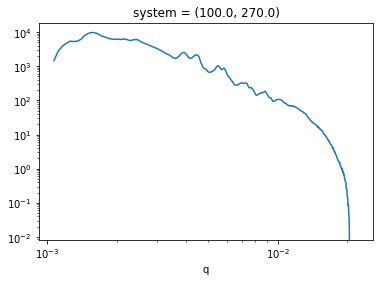

In [26]:
int_hdr.sel(polarization=100,energy=270).mean('chi').plot(xscale='log',yscale='log')

In [58]:
import numpy as np
foo_hdr[1].coords['system'].values = foo_hdr[1].coords['system'].values[()][1][np.newaxis]


ValueError: replacement data must match the Variable's shape. replacement data has shape (1,); Variable has shape ()

In [65]:
raw_xr.coords['system'].values.ndim

1

In [55]:
foo_hdr[1].system

<xarray.DataArray 'system' ()>
array((190.0, 320.01), dtype=object)
Coordinates:
    system   object (190.0, 320.01)

In [145]:
int_hdr = integrator.integrateImageStack(raw_hdr)

AttributeError: 'DataArray' object has no attribute 'energy'

A side warning here: if you are using my example data, at this point the memory usage will be kind of insane (~20 GB peak, about 15.5 GB at rest).  We can clean up by tossing the raw data and integrator, which will take us down to something ~2 GB:

In [ ]:

integrator = None

As with the raw data, we can slice this using standard select commands, and even plot using the core xarray plotting.

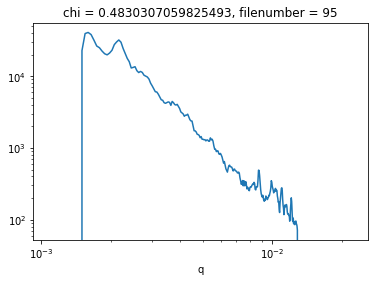

In [17]:
int_xr.sel(energy=270,polarization=100,exposure=1.002, chi=0,method='nearest').plot(xscale='log',yscale='log')

We can use slicing to punch out energy scans, for example: (this gets a little gross, probably I need an xarray cleanup function)

In [18]:
pol100chi0 = int_xr.sel(polarization=100,chi=0,method='nearest')
pol100chi0

<xarray.DataArray (system: 92, q: 500)>
array([[nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * q           (q) float64 2.377e-05 7.132e-05 0.0001189 ... 0.0237 0.02375
    chi         float64 0.483
  * system      (system) MultiIndex
  - energy      (system) float64 310.0 289.5 282.8 284.8 ... 284.0 286.0 280.0
  - exposure    (system) float64 1.002 1.002 0.003 0.102 ... 0.102 0.102 0.003
  - filenumber  (system) int64 92 84 10 47 51 6 71 26 ... 91 29 68 87 13 44 52 5
Attributes:
    SIMPLE:                         True
    BITPIX:                         8
    NAXIS:                          0
    EXTEND:                         True
    COMMENT:                            and Astrophysics', volume 376, page 3...
    EXPOSURE:                       1.0
    TEMP:                           -44.5
    RINGCRNT:                       500.060339355469
    DATE:                           2019-12-05T17:18:47
    ROI_L:                          1309
    ROI_T:                          526
    ROI_R:                          2539
    ROI_B:                          1627
    EPU Polarization:               100.0
    Coolstage Temp C:               0.0
    CCD Temperature:                -45.0
    Beam Current:                   500.132818603515
    TEY signal:                     -0.00136385642089821
    IZERO:                          -0.698759368088832
    Photodiode:                     -0.0174415487398088
    AI 0:                           0.0105281275274171
    AI 3 Izero:                     0.25842225556108
    AI 5:                           0.257279214499274
    AI 6 BeamStop:                  -35.2255056410498
    AI 7:                           -0.00296600067684033
    Temperature Controller:         0.0
    PZT Shutter:                    0.0
    Pause Trigger:                  0.0
    LV Memory:                      345552.0
    Time Stamp Error:               -0.0127792358398438
    Time Stamp Transmit Time:       1.27750742062926
    Time Stamp Server Time:         0.722492579370737
    Sample Azimuthal Rotation:      0.0
    Piezo Vertical:                 0.0
    Piezo Horiz:                    0.0
    Sample X:                       0.802
    Sample Y:                       -16.977
    Sample Z:                       -2.0
    Sample Theta:                   90.0
    Sample Y Scaled:                -15.9531616230824
    CCD Theta:                      -1.219
    Beam Stop:                      -10.447
    Pollux CCD X:                   0.0
    Pollux CCD Y:                   0.0
    CCD X:                          99.83
    CCD Y:                          100.0
    CCD Temperature Setpoint:       -45.0
    T-2T:                           90.0
    Beamline Energy:                309.999784281053
    Mono 101 Grating:               -36.1801606083782
    Beamline Energy Goal:           0.0
    Entrance Slit width:            35.0
    Exit Slit Left:                 3608.0
    Exit Slit Right:                8910.0
    Horizontal Exit Slit Size:      1500.0
    Horizontal Exit Slit Position:  -700.0
    Vertical Exit Slit Size:        25.9000000000001
    Vertical Exit Slit Position:    0.259999999999991
    EPU Gap:                        28.6995375
    EPU Z:                          -1.52587887711393e-09
    Mono Energy:                    309.999784281053
    M103 Yaw:                       2.205
    M103 Bend Up:                   0.5595
    M103 Bend Down:                 1.0033
    M101 Feedback:                  0.0
    M101 Horizontal Deflection:     2.002
    M101 Vertical Deflection:       -13.504
    Vertical Slit Position:         0.259999999999991
    Vertical Slit Size:             25.9000000000001
    Horizontal Slit Position:       -700.0
    Mono 101 Vessel:            

The one crude thing we have to do - remember that 'filenumber' axis we put in?  We need to get rid of it for auto-plotting to work... so we'll unstack the system multiindex (like a compound axis, done above) and select all values of the filenumber coordinate.  We also need to put the array in the right order for auto-plotting.

In [19]:
pol100chi0 = pol100chi0.sel(filenumber=slice(0,500)).sel(exposure=slice(0.08,0.11))
pol100chi0 = pol100chi0.drop('chi').sortby('energy').sortby('q')
pol100chi0

<xarray.DataArray (energy: 45, q: 500)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.]])
Coordinates:
  * q        (q) float64 2.377e-05 7.132e-05 0.0001189 ... 0.0237 0.02375
  * energy   (energy) float64 270.0 270.0 280.0 281.0 ... 310.0 315.0 320.0
Attributes:
    SIMPLE:                         True
    BITPIX:                         8
    NAXIS:                          0
    EXTEND:                         True
    COMMENT:                            and Astrophysics', volume 376, page 3...
    EXPOSURE:                       1.0
    TEMP:                           -44.5
    RINGCRNT:                       500.060339355469
    DATE:                           2019-12-05T17:18:47
    ROI_L:                          1309
    ROI_T:                          526
    ROI_R:                          2539
    ROI_B:                          1627
    EPU Polarization:               100.0
    Coolstage Temp C:               0.0
    CCD Temperature:                -45.0
    Beam Current:                   500.132818603515
    TEY signal:                     -0.00136385642089821
    IZERO:                          -0.698759368088832
    Photodiode:                     -0.0174415487398088
    AI 0:                           0.0105281275274171
    AI 3 Izero:                     0.25842225556108
    AI 5:                           0.257279214499274
    AI 6 BeamStop:                  -35.2255056410498
    AI 7:                           -0.00296600067684033
    Temperature Controller:         0.0
    PZT Shutter:                    0.0
    Pause Trigger:                  0.0
    LV Memory:                      345552.0
    Time Stamp Error:               -0.0127792358398438
    Time Stamp Transmit Time:       1.27750742062926
    Time Stamp Server Time:         0.722492579370737
    Sample Azimuthal Rotation:      0.0
    Piezo Vertical:                 0.0
    Piezo Horiz:                    0.0
    Sample X:                       0.802
    Sample Y:                       -16.977
    Sample Z:                       -2.0
    Sample Theta:                   90.0
    Sample Y Scaled:                -15.9531616230824
    CCD Theta:                      -1.219
    Beam Stop:                      -10.447
    Pollux CCD X:                   0.0
    Pollux CCD Y:                   0.0
    CCD X:                          99.83
    CCD Y:                          100.0
    CCD Temperature Setpoint:       -45.0
    T-2T:                           90.0
    Beamline Energy:                309.999784281053
    Mono 101 Grating:               -36.1801606083782
    Beamline Energy Goal:           0.0
    Entrance Slit width:            35.0
    Exit Slit Left:                 3608.0
    Exit Slit Right:                8910.0
    Horizontal Exit Slit Size:      1500.0
    Horizontal Exit Slit Position:  -700.0
    Vertical Exit Slit Size:        25.9000000000001
    Vertical Exit Slit Position:    0.259999999999991
    EPU Gap:                        28.6995375
    EPU Z:                          -1.52587887711393e-09
    Mono Energy:                    309.999784281053
    M103 Yaw:                       2.205
    M103 Bend Up:                   0.5595
    M103 Bend Down:                 1.0033
    M101 Feedback:                  0.0
    M101 Horizontal Deflection:     2.002
    M101 Vertical Deflection:       -13.504
    Vertical Slit Position:         0.259999999999991
    Vertical Slit Size:             25.9000000000001
    Horizontal Slit Position:       -700.0
    Mono 101 Vessel:                25.0
    Horizontal Slit Size:           1500.0
    Diag 106:                       95.0
    M121 Translation:               17.99971
    PiezoShutter Trans:             18.9567857142857
    Higher Order Suppressor:        7.500

/Users/pab2/opt/anaconda3/envs/rsoxs/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


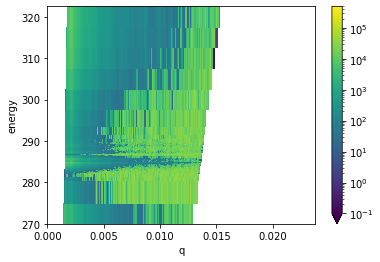

In [22]:
from matplotlib.colors import LogNorm
pol100chi0.plot(norm=LogNorm(1e-1,5e5))

For fitting, we can use the xarray split-apply-combine paradigm to automate things nicely.
Skipping the array prep for now, but here is the syntax.  This part is very much work in progress.

In [145]:
import Fitting
from Fitting import fit_lorentz_bg

In [277]:
lor0p002_p100_e0p1_chi0 = (pol100e0p1
       .coarsen(chi=10).mean()      #you can either coarsen chi (where number is an integer number of bins
                                     #over which to do a moving average), or
       #.sel(chi=0,method='nearest')  #you can just select a single chi stripe, if you do this, you can't stack
       .stack(echi=['energy','chi']) 
       .sel(q=slice(0.0018,0.0025))
       .groupby('echi')
       .map(fit_lorentz_bg,guess=[0,0,0.0002,2e-8],pos_int_override=True)
       .unstack('echi'))
lor0p002_p100_e0p1_chim90 = (pol100e0p1
       #.coarsen(chi=15).mean()      #you can either coarsen chi (where number is an integer number of bins
                                     #over which to do a moving average), or
       .sel(chi=-90,method='nearest')  #you can just select a single chi stripe, if you do this, you can't stack
       .stack(echi=['energy'])#,'chi'])
       .sel(q=slice(0.0018,0.0025))
       .groupby('echi')
       .map(fit_lorentz,guess=[0,0,0.0002],pos_int_override=True)
       .unstack('echi'))

lor0p002_p100_e0p1_chim90 = (pol100e0p1
       .sel(chi=-90,method='nearest')  #you can just select a single chi stripe, if you do this, you can't stack
       .sel(q=slice(0.0018,0.0025))
       .map(fit_lorentz,guess=[0,0,0.0002],pos_int_override=True)



Starting fit on Coordinates:
    chi      float64 0.483
  * q        (q) float64 0.001839 0.001888 0.001937 ... 0.002426 0.002475
    echi     object (270.0,)
Fit completed, coeff = [5.58710261e-09 2.14143365e-03 1.28799515e-04 4.10084458e-09]
Starting fit on Coordinates:
    chi      float64 0.483
  * q        (q) float64 0.001839 0.001888 0.001937 ... 0.002426 0.002475
    echi     object (280.0,)
Fit completed, coeff = [1.22653626e-09 2.14293984e-03 1.36948357e-04 5.79321512e-10]
Starting fit on Coordinates:
    chi      float64 0.483
  * q        (q) float64 0.001839 0.001888 0.001937 ... 0.002426 0.002475
    echi     object (281.0,)
Fit completed, coeff = [5.35843435e-10 2.19031094e-03 1.05557154e-04 2.52267420e-10]
Starting fit on Coordinates:
    chi      float64 0.483
  * q        (q) float64 0.001839 0.001888 0.001937 ... 0.002426 0.002475
    echi     object (282.0,)
Fit completed, coeff = [ 2.63434223e-10  2.10201348e-03  5.36061360e-04 -1.38503819e-10]
Starting fit on Coor